# 水果辨識及價格
### 組員
106701043 統計三 鄭書承  
107304050 統計二 柯敦瀚  
106405069 廣告三 謝繐宇  
106502045 阿文三 廖俞瑞  
### 分工
蒐集資料：鄭書承、謝繐宇、柯敦瀚、廖俞瑞   
爬蟲：鄭書承、廖俞瑞    
模型：鄭書承、柯敦瀚、廖俞瑞、謝繐宇  
PPT製作：謝繐宇、柯敦瀚

# 資料介紹
使用網站Zenodo裡面的Fruit Recognition dataset作為訓練資料。該網站資料集提供蘋果、蓮霧、楊桃等水果總計13種，每種水果三千張照片，總計四萬多筆，並且已將每種水果的照片案資料夾放好，我們從每個水果的資料夾中挑出300張照片做為測試集，剩下的作為訓練集。
# 動機
隨著健康意識的抬頭，許多人開始注意飲食均衡，為了在平常食物攝取中能保持營養均衡而購買水果，但很多人在購買水果時無法妥善的分辨水果與其合理時價而導致荷包受損。
因此我們想製作一個模型來辨識水果後能報上此水果的時價，讓大家可以輕鬆使用與用合理時價購買。
# 問題
在利用Zenodo Fruit Recognition dataset的資料建立並訓練模型，能夠判斷水果種類之後，再結合爬蟲從twfood網站上爬取該水果合理價錢，此外，為了方便消費者查詢，將此程式做成APP的形式，我們選擇使用MobileNet作為模型。

## 0. MobileNet

1. MobileNet 是基於 Depthwise separable convolution 構建的網絡，希望在不影響輸出結構的狀況下減少運算量，基本上可以拆成兩部分：  
深度卷積(depthwise convolution) 和逐點卷積(pointwise convolution)  
    - Depthwise convolution 和標準卷積不同，標準卷積其卷積核是用在所有的輸入通道上，而 Depthwise convolution 針對每個輸入通道採用不同的捲積核，就是說一個卷積核對應一個輸入通道
    - Pointwise convolution 其實就是普通的卷積，只不過其採用1x1的卷積
![](MobileNet2.jpg)
2. 這樣子的作法有什麼好處呢？  
假設輸入尺寸為 $D_F \times D_F \times M$， strides 為1且 padding 為1 也就是做完一次卷積之後圖片大小還是一樣$D_F \times D_F$  
(1)採用標準卷積核進行卷積：標準卷積核的尺寸為 $D_K \times D_K \times M \times N$，那麼輸出尺寸應該為 $D_F \times D_F \times N$，計算量為 $D_F \times D_F \times M \times N \times D_K \times D_K$   
![](2.png)
(2)採用 Depthwise separable convolution 的方式進行卷積：
    - 先使用 M 個Depthwise Convolution 對輸入的M個通道分別進行卷積得到尺寸為$D_F \times D_F \times M$，這一步的計算量為$D_F \times D_F \times M \times D_K \times D_K$  
![](4.png)
    - 再使用 N 個Pointwise convolution $1 \times 1 \times M$ 的卷積核進行逐點卷積得到輸出尺寸為$D_F \times D_F \times M \times N$，這一步的計算量為$D_F \times D_F \times M \times N $  
故總的計算量為 $D_F \times D_F \times M \times D_K \times D_K + D_F \times D_F \times M \times N $  
![](3.png)
最後再將兩者合併，可以看出 Depthwise separable convolution 的輸入和輸出結果量是可以跟一般卷積計算一樣的。
![](1.png) 

    (3)Depthwise separable convolution 的計算量與標準卷積相比： 
<font size="5">$\frac{D_F \times D_F \times M \times N \times D_K \times D_K}{D_F \times D_F \times M \times D_K \times D_K + D_F \times D_F \times M \times N} = \frac{1}{N} + \frac{1}{D_K^2} $</font><br />  
可以看到當 N (卷積核的數目) 及 $D_K$ (卷積核的大小) 越大時，兩者的運算量就差越多

3. MobileNet 及 Inception 比較
    - MobileNet 及 Inception 皆是可以運行在TFLlite 框架下的模型  
    - 可以看到MobileNet 在損失一點準確率的情況下，將模型大小縮小了好幾倍
![](MobileNet&Inception.PNG)
4. 為甚麼選擇MobileNet？
    - 手機的硬體並不像電腦一樣強大，例如：CPU、記憶體
    - MobileNet 在準確率及模型大小取得良好的平衡
    - TFLite 是 Tensorflow 提供給創作者可以將模型放到移動裝置上運行的解決方案，MobileNet便是少數的模型之一

## 1. 匯入套件及模型

In [60]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet, MobileNetV2
from tensorflow.keras.layers import Activation, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

In [2]:
# 只選取其中和圖片有關的，並將輸入層改為(320, 258, 3)，因為訓練圖片大小是這樣
mobile = MobileNetV2(weights='imagenet' ,include_top=False, input_shape = (320, 258, 3))

In [106]:
mobile.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 320, 258, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 321, 259, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 129, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 160, 129, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

## 2. 資料處理

In [21]:
# 將訓練資料以Generator形式呈現並經過前置處理
train_datagen=image.ImageDataGenerator(preprocessing_function=preprocess_input) 
train_generator=train_datagen.flow_from_directory(r"C:\Users\j3192\Desktop\Jupyter Notebook\計算機程式\fruit_data\train",
                                                target_size=(320,258),
                                                color_mode='rgb',
                                                batch_size=50,
                                                class_mode='categorical',
                                                shuffle=True)

Found 38039 images belonging to 14 classes.


In [3]:
# 將測試資料以Generator形式呈現並經過前置處理
test_datagen = image.ImageDataGenerator(preprocessing_function = preprocess_input)
test_generator = test_datagen.flow_from_directory(r'C:\Users\j3192\Desktop\Jupyter Notebook\計算機程式\fruit_data\test',
                                                 target_size = (320,258),
                                                 color_mode = 'rgb',
                                                 batch_size = 50,
                                                 class_mode = 'categorical',
                                                 shuffle = True)

Found 4200 images belonging to 14 classes.


## 3. 建立模型

In [38]:
# 將MobileNet前面幾層凍結只訓練後面13層
for layer in mobile.layers[:-13]:
    layer.trainable = False

In [39]:
# 因為原本MobileNet可以辨識1000種類的東西，但我們只有14種水果，因此將後面幾層刪除並新增最後輸出為14種類
x = mobile.layers[-1].output
x = GlobalAveragePooling2D()(x)
pre = Dense(14, activation='softmax')(x)
new_model = Model(mobile.input, pre)

In [40]:
new_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics = ['accuracy'])

In [46]:
new_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 320, 258, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 321, 259, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 160, 129, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 160, 129, 32) 128         Conv1[0][0]                      
___________________________________________________________________________________________

## 4. 訓練資料

In [42]:
# 若訓練超過8次以上 val_accuracy 沒有增加超過0.005則提前停止訓練
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0.005, mode='max', patience = 8 )
history3 = new_model.fit_generator(generator = train_generator, 
                                  epochs = 25,
                                  callbacks = [early_stopping],
                                  validation_data = test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 761 steps, validate for 84 steps
Epoch 1/25
761/761 [==============================] - 642s 844ms/step - loss: 0.0542 - accuracy: 0.9831 - val_loss: 7.7220 - val_accuracy: 0.5133
Epoch 2/25
761/761 [==============================] - 637s 837ms/step - loss: 0.0084 - accuracy: 0.9973 - val_loss: 4.1708 - val_accuracy: 0.6440
Epoch 3/25
761/761 [==============================] - 637s 837ms/step - loss: 0.0081 - accuracy: 0.9976 - val_loss: 1.8179 - val_accuracy: 0.8019
Epoch 4/25
761/761 [==============================] - 636s 836ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 3.0550 - val_accuracy: 0.7343
Epoch 5/25
761/761 [==============================] - 636s 836ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 7.6127 - val_accuracy: 0.5776
Epoch 6/25
761/761 [==============================] - 636s 836ms/step - loss: 0.0048 - accuracy: 0.9988 - val_loss: 2.5146 - val_accuracy: 0.8002
Epoch 7/25
761/761 [===========

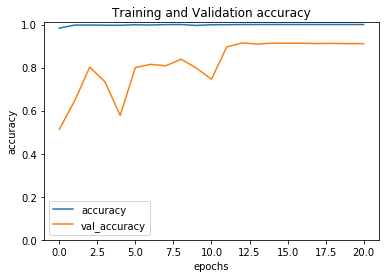

In [61]:
plt.plot(history3.history['accuracy'], label = 'accuracy')
plt.plot(history3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.ylim(0, 1.01)
plt.title('Training and Validation accuracy')
plt.legend()

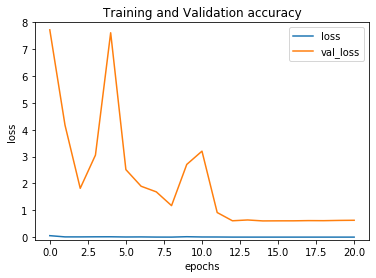

In [62]:
plt.plot(history3.history['loss'], label='loss')
plt.plot(history3.history['val_loss'], label = 'val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(-0.1, 8)
plt.title('Training and Validation accuracy')
plt.legend()

## 5. 網路爬蟲水果價格

In [68]:
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [69]:
# 爬取網站上所有的水果種類
df = pd.DataFrame({})
L = ['熱帶水果', '硬核類', '高山類', '厚皮類', '薄皮類', '瓜類', '柑橘柚類']
for category in L:
    res = requests.get(f'https://www.twfood.cc/topic/fruit/{category}')
    soup = BeautifulSoup(res.text, 'html.parser')
    fruit = soup.select('#vege_chart > div.col-xs-12.col-sm-12.col-md-3.widget.to_animate.animated.fadeInLeft > div > div.col-xs-6.col-sm-6.col-md-12.vege_price')
    names = soup.select('#vege_chart > div.col-xs-12.col-sm-12.col-md-3.widget.to_animate.animated.fadeInLeft > div > div.col-xs-6.col-sm-6.col-md-12.vege_price > h4 > a')
    num = len(fruit)
    for i in range(num):
        name = names[i].text.replace(" ", "").replace(f'推薦No:{i+1}', '').strip()
        estimated_price = fruit[i].find_all('span', {'class':'text-price'})[3].text
        ser = pd.Series({"estimated_price":estimated_price}, name = name)
        df = df.append(ser)
df = df.astype('float64')

In [70]:
# 因為有些水果並沒有分類，所以要以輸入關鍵字的方式搜尋
def search(search):
    res = requests.get(f'https://www.twfood.cc/search?q={search}')
    soup = BeautifulSoup(res.text, 'html.parser')
    fruit = soup.find_all('div', {'class':'row search_result'})[0]
    name = fruit.find_all({'a':'href'})[0].text.strip()
    new_url = 'https://www.twfood.cc' + fruit.find_all('a')[0]['href']
    new_res = requests.get(new_url)
    new_soup = BeautifulSoup(new_res.text, 'html.parser')
    estimated_price = new_soup.find_all('span', {'class':'text-price'})[3].text
    return float(estimated_price)

In [111]:
# 找尋所有同種水果的價格並將其平均
class_names = ['蘋果', '香蕉', '楊桃', '芭樂', '奇異果', '芒果', '甜瓜', '橘子', '桃子', '梨', '柿子', '火龍果', '李', '番茄']
price = []
for cls in class_names:
    L = []
    for name in df .index:
        if (cls + '-' in name) or (f'({cls})' in name):
            L.append(df.loc[name, 'estimated_price'])
    price.append(search(cls)) if len(L) == 0 else price.append(np.array(L).mean().round())    

In [112]:
# 將水果名稱和價錢放在一起並用 utf-8 的方式寫入避免產生亂碼
name_price = [combination for combination in zip(class_names, price)]
name_price = [f'{item[0]} ${item[1]}\n'.encode('utf-8') for item in name_price]

In [115]:
# 將標籤寫成檔案
with open(r"C:\Users\j3192\Desktop\TFLite_example\lite\examples\image_classification\android\app\src\main\assets\labels.txt", 'wb') as f:
    f.writelines(name_price)

## 6. 測試

In [92]:
result = new_model.predict(test_generator)

In [93]:
from ipywidgets import interact_manual

In [95]:
# 因為 array 一次不能儲存那麼大所以分批 reshape再合起來
x_test = []
for j in range(3):
    if 30*(j+1)*50 < len(result):
        L = [test_generator[i][0] for i in range(30*j, 30*(j+1))]
        res = list(np.array(L).reshape(1500, 224, 224, 3))
        print(np.array(L).shape)
    else:
        L = [test_generator[i][0] for i in range(30*j, int(len(result)/50))]
        res = list(np.array(L).reshape(len(result) - 30*j*50, 224, 224, 3))
        print(np.array(L).shape)
        
    x_test.extend(res)

(30, 50, 224, 224, 3)
(30, 50, 224, 224, 3)
(24, 50, 224, 224, 3)


In [100]:
def show(n):
    plt.imshow(x_test[n] + 0.3)
    print("預測：", class_names[np.where(result[n] == result[n].max())[0][0]])
    print('合理價格為：', price[np.where(result[n] == result[n].max())[0][0]])

In [101]:
from ipywidgets import interact_manual
interact_manual(show,  n = (0, 4200))

interactive(children=(IntSlider(value=2100, description='n', max=4200), Button(description='Run Interact', sty…

<function __main__.show(n)>

  ## 7. 儲存並轉成TFLite

In [43]:
new_model.save('fruit_model3.h5')  

In [44]:
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
tflite_model = converter.convert()
open('fruit3.tflite', 'wb').write(tflite_model)

8923956

## 8. 匯出成一個APP
1. 尋找Git Hub上的Demo並下載  
2. 利用Android Studio匯入檔案
3. 將內建的model及labels改成我們的
4. Build並匯出成APP ( https://github.com/bookbnnbnn/TFLite_example )

## 9. 結果與討論

![](fruit.png)

__優點__：
- 可以看出圖片的辨識度都蠻高的且運算速度相當快  

__缺點__：
- 沒有訓練關於食物的剖面圖  
- 沒有辦法辨識同種水果但品種不同，畢竟價格可能相差很多  
- 沒辦法即時更新最新的合理價格